# Rotational dynamics Quickstart

Calculation of rotational dynamics proceeds in two steps. At the first step, we obtain molecular field-free rotational energies, wave functions, and matrix elements of desired electric and magnetic property tensors, such as, for example, dipole moment or polarizability. At the second step, we solve the time-dependent problem with applied external electric and magnetic fields using the field-free solutions obtained at the first step as basis.

## Molecular field-free rotational states

In [1]:
from richmol.rot import Molecule, mol_tensor
from richmol.rot import solve

There are three common ways to define molecule and its properties, using calculated or experimental data or combination of both:

1. Provide Cartesian coordinates of atoms and molecular property tensors, referring to the same coordinate frame, obtained, for example, from quantum chemical calculations.

2. Provide spectroscopic constants ($A$, $B$, $C$, $\Delta_{J}$, $\Delta_{J,K}$ ...) and molecular property tensors in the coordinate frame of principal axes of inertia (PAI).

3. Provide spectroscopic constants ($A$, $B$, $C$, $\Delta_{J}$, $\Delta_{J,K}$ ...) and molecular property tensors which are not in the PAI frame. In this case, the Cartesian coordinates of atoms, defined with respect to the same frame as property tensors, must be provided. These will be used only for transforming the property tensors to the PAI frame.

### Molecular geometry and property tensors

Here is an example for water molecule, using data obtained from a quantum chemical calculation

In [2]:
water = Molecule()

# Cartesian coordinates of atoms
water.XYZ = ("bohr",
             "O",  0.00000000,   0.00000000,   0.12395915,
             "H",  0.00000000,  -1.43102686,  -0.98366080,
             "H",  0.00000000,   1.43102686,  -0.98366080)

# dipole moment (au)
water.dip = [0, 0, -0.7288]

# polarizability tensor (au)
water.pol = [[9.1369, 0, 0], [0, 9.8701, 0], [0, 0, 9.4486]]

print("Masses and Cartesian coordinates of atoms")
for atom in water.XYZ:
    print(atom['label'], atom['mass'], atom['xyz'])

Masses and Cartesian coordinates of atoms
O 15.99491462 [0.         0.         0.06559636]
H 1.0078250322 [ 0.         -0.7572668  -0.52053088]
H 1.0078250322 [ 0.          0.7572668  -0.52053088]


By default, calculations are carried out for the main isotopologue. To specify a non-standard isotope, put the corresponding isotope number next to the atom label, for example, "O18" for oxygen-18 or "H2" for deuterium

In [3]:
# example of D2^{18}O
D2_18O = Molecule()
D2_18O.XYZ = ("bohr",
             "O18",  0.00000000,   0.00000000,   0.12395915,
             "H2",   0.00000000,  -1.43102686,  -0.98366080,
             "H2",   0.00000000,   1.43102686,  -0.98366080)

print("Masses and Cartesian coordinates of atoms")
for atom in D2_18O.XYZ:
    print(atom['label'], atom['mass'], atom['xyz'])

Masses and Cartesian coordinates of atoms
O18 17.999159613 [0.         0.         0.06559636]
H2 2.0141017781 [ 0.         -0.7572668  -0.52053088]
H2 2.0141017781 [ 0.          0.7572668  -0.52053088]


We can also read/store the geometry from/to XYZ file

In [4]:
# store Cartesian coordinates of atoms into XYZ file
water.store_xyz("water.xyz", "some comment line")

# read Cartesian coordinates of atoms from XYZ file
water2 = Molecule()
water2.XYZ = "water.xyz"

print("Masses and Cartesian coordinates of atoms")
for atom in water2.XYZ:
    print(atom['label'], atom['mass'], atom['xyz'])

Masses and Cartesian coordinates of atoms
O 15.99491462 [0.         0.         0.06559636]
H 1.0078250322 [ 0.         -0.7572668  -0.52053088]
H 1.0078250322 [ 0.          0.7572668  -0.52053088]


The molecular frame embedding, i.e., the orientation of $x,y,z$ axes with respect to molecule, can be altered using `frame`.
The molecule properties `dip` for the dipole moment and `pol` for the polarizability tensor (and few others) will be dynamically rotated to a new coordinate frame whenever the latter is changed

In [5]:
# change frame to inertial principal axes system (ipas)
water.frame = "ipas"

# or equivalently
water.frame = "diag(inertia)" # reads as: frame where the inertia tensor is diagonal

print("coordinates of atoms\n", water.XYZ)
print("dipole moment\n", water.dip)
print("polarizability\n", water.pol)

print("inertia tensor\n", water.inertia)

coordinates of atoms
 [('O', 15.99491462, [ 0.        ,  0.06559636,  0.        ])
 ('H',  1.00782503, [-0.7572668 , -0.52053088,  0.        ])
 ('H',  1.00782503, [ 0.7572668 , -0.52053088,  0.        ])]
dipole moment
 [ 0.     -0.7288  0.    ]
polarizability
 [[9.8701 0.     0.    ]
 [0.     9.4486 0.    ]
 [0.     0.     9.1369]]
inertia tensor
 [[ 0.61496945 -0.         -0.        ]
 [-0.          1.1558806  -0.        ]
 [-0.         -0.          1.77085004]]


Multiple frame operations can be combined together, for example, we can rotate to the inertial principal axes system and then permute $x$ and $z$ axes

In [6]:
water.frame = "ipas"
water.frame = "zyx"

# or equivalently in one line (with operations performed form right to left)
water.frame = "zyx,ipas"

print("coordinates of atoms\n", water.XYZ)
print("dipole moment\n", water.dip)
print("polarizability\n", water.pol)

print("inertia tensor\n", water.inertia)

coordinates of atoms
 [('O', 15.99491462, [ 0.        ,  0.06559636,  0.        ])
 ('H',  1.00782503, [ 0.        , -0.52053088, -0.7572668 ])
 ('H',  1.00782503, [ 0.        , -0.52053088,  0.7572668 ])]
dipole moment
 [ 0.     -0.7288  0.    ]
polarizability
 [[9.1369 0.     0.    ]
 [0.     9.4486 0.    ]
 [0.     0.     9.8701]]
inertia tensor
 [[ 1.77085004 -0.         -0.        ]
 [-0.          1.1558806  -0.        ]
 [-0.         -0.          0.61496945]]


The principal axes system can be defined with respect to any rank-2 symmetric matrix. For example, in many cases it is convenient to choose molecular frame such that polarizability tensor becomes diagonal

In [7]:
water.frame = "diag(pol)" # reads as: frame where tensor 'pol' is diagonal

print("coordinates of atoms\n", water.XYZ)
print("dipole moment\n", water.dip)
print("polarizability\n", water.pol)


coordinates of atoms
 [('O', 15.99491462, [ 0.        ,  0.06559636,  0.        ])
 ('H',  1.00782503, [ 0.        , -0.52053088, -0.7572668 ])
 ('H',  1.00782503, [ 0.        , -0.52053088,  0.7572668 ])]
dipole moment
 [ 0.     -0.7288  0.    ]
polarizability
 [[9.1369 0.     0.    ]
 [0.     9.4486 0.    ]
 [0.     0.     9.8701]]


We can also define custom rotation matrix or principal axis matrix, as demonstrated below

In [8]:
import numpy as np
import scipy.linalg as la

# generate random matrix
mat = np.random.rand(3,3)

# random rotation matrix
water.custom_rot = la.expm((mat - mat.T)/2)

# random symmetric matrix
water.custom_pam = (mat + mat.T)/2

# use 'custom_rot' (orthogonal) matrix to rotate the frame
water.frame = "custom_rot"

# alternatively use 'custom_pam' (symmetric) matrix as principal axes matrix
water.frame = "diag(custom_pam)"

Multiple occurences of `frame` assignments lead to the accumulation of the corresponding frame transformations. Use `frame`=None or `frame`="None" to reset the frame to the one defined by the input Cartesian coordinates of atoms

In [9]:
water.frame = "diag(inertia)" # rotate to ipas
water.frame = "zxy" # then permute axes (123)

# now we want to permute axes (23) in the original frame, reset frame rotation
water.frame = None
water.frame = "xzy"

# or equivalently in one line
water.frame = "xzy,None"

print(water.XYZ)

[('O', 15.99491462, [ 0.        ,  0.06559636,  0.        ])
 ('H',  1.00782503, [ 0.        , -0.52053088, -0.7572668 ])
 ('H',  1.00782503, [ 0.        , -0.52053088,  0.7572668 ])]


Only certain molecule properties (such as `dip`, `pol`, `inertia`, `XYZ`, and few others) are automatically rotated when the frame is altered. This is demonstrated in the following example

In [10]:
water.vec = [1,2,3]
water.mat = [[1,2,3],[4,5,6],[7,8,9]]

water.frame = "zyx,null"

# axes permutation (13) does not affect vec and mat, but dip
print("vec\n", water.vec)
print("mat\n", water.mat)
print("dip\n", water.dip)

vec
 [1, 2, 3]
mat
 [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
dip
 [-0.7288  0.      0.    ]


To declare a custom Cartesian tensor which is dynamically rotated to a new frame, use `mol_tensor` function

In [11]:
water.vec = mol_tensor([1,2,3])
water.mat = mol_tensor([[1,2,3],[4,5,6],[7,8,9]])

water.frame = "zyx,null"

# axes permutation (13) now affects also vec and mat
print("vec\n", water.vec)
print("mat\n", water.mat)
print("dip\n", water.dip)

# we can then change vec and mat values, they will still be dynamically rotated
water.vec = [7,8,9]
water.mat = [[11,12,13],[14,15,16],[17,18,19]]

print("\nnew vec\n", water.vec)
print("new mat\n", water.mat)

vec
 [3. 2. 1.]
mat
 [[9. 8. 7.]
 [6. 5. 4.]
 [3. 2. 1.]]
dip
 [-0.7288  0.      0.    ]

new vec
 [9. 8. 7.]
new mat
 [[19. 18. 17.]
 [16. 15. 14.]
 [13. 12. 11.]]


### Rotational constants

The rotational constants (in units of cm$^{-1}$) can be calculated from the input molecular geometry using `ABC`. This will work only if the molecular frame is set to the inertial principal axes system or if the inertia tensor is diagonal

In [12]:
water.frame = "diag(pol)" # frame where polarizability tensor is diagonal
print(water.ABC) # works because inertia tensor happens to be diagonal in the selected frame

water.frame = "diag(inertia)"
print(water.ABC) # the rotational constants in the inertia frame will be sorted in ascending order

[9.519512542010801, 14.584230612810305, 27.412141069544163]
[27.412141069544163, 14.584230612810305, 9.519512542010801]


The values of rotational constants can also be user specified, for example, by setting them to experimental values. In these case, `ABC` will always return the user-defined values. To access the rotational constants calculated from the molecular geometry, use `ABC_geom`

In [13]:
print("water.ABC ", water.ABC)
water.ABC = (9.285, 14.512, 27.877) # user-defined rotational constants in units of cm^-1
print("water.ABC ", water.ABC)
print("water.ABC_geom ", water.ABC_geom)

water.ABC  [27.412141069544163, 14.584230612810305, 9.519512542010801]
water.ABC  [27.877, 14.512, 9.285]
water.ABC_geom  [27.412141069544163, 14.584230612810305, 9.519512542010801]


***************************

**Important**: If user-defined rotational constants have been specified, the rotational Hamiltonian is built using these values

***************************

For linear and spherical-top molecules, use `B` to print and assign the rotational constant

In [14]:
ocs = Molecule()
ocs.B = 0.20286 # experimental value
print(ocs.B)

ocs.XYZ = ("angstrom", "C", 0, 0, 0, "S", 0, 0, -1.56, "O", 0, 0, 1.16)
print(ocs.B_geom) # calculated value

print(ocs.linear()) # True if molecule is linear

0.20286
0.20317859211971495
True


If the molecular geometry is specified, the user-input rotational constants are always checked to agree within 5% difference with the values calculated from molecular geometry. Here is an example of an error produced when molecular frame is not in the inertial principal axes system

In [15]:
water2 = Molecule()
water2.ABC = (9.285, 14.512, 27.877) # user-defined rotational constants in units of cm^-1

water2.XYZ = ("bohr",
              "O",  0.00000000,   0.00000000,   0.12395915,
              "H",  0.00000000,  -1.43102686,  -0.98366080,
              "H",  0.00000000,   1.43102686,  -0.98366080)

# polarizability tensor (au)
water2.pol = [[9.1369, 0, 0], [0, 9.8701, 0], [0, 0, 9.4486]]

water2.frame = 'ipas' # inertia principal axes system
print("inertia frame")
print("calculated ABC", water2.ABC_geom)
print("input ABC     ", water2.ABC)

water2.frame = 'diag(pol)' # polarizability principal axes system
print("\npolarizability frame")
print("calculated ABC", water2.ABC_geom)
print("input ABC     ", water2.ABC) # specified rotaitonal constants disagree much with the geometry 

inertia frame
calculated ABC [27.412141069544163, 14.584230612810305, 9.519512542010801]
input ABC      [27.877, 14.512, 9.285]

polarizability frame
calculated ABC [9.519512542010801, 14.584230612810305, 27.412141069544163]


ValueError: input rotational constants disagree much with geometry
        exp          calc       exp-calc
A    27.877000     9.519513    18.357487
B    14.512000    14.584231    -0.072231
C     9.285000    27.412141   -18.127141

### Rotational solutions 

The rotational energies and wave functions can be calculated for a specified range of $J$ quantum number using function `solve`

In [16]:
sol = solve(water, Jmin=0, Jmax=10)

Returned object is a dictionary `sol[J][sym]` containing solutions for different values of $J$ and different symetries (of $C_1$ group by default). The state energies (in cm$^{-1}$) and assignments (by $J, k, \tau$ quantum numbers) can be printed out as following

In [17]:
print("J  sym #    energy      J   k  tau  |leading coef|^2")
for J, sol_J in sol.items():
    for symmetry, sol_sym in sol_J.items():
        for istate in range(sol_sym.nstates):
            print(J, "%4s"%symmetry, istate, "%12.6f"%sol_sym.enr[istate], sol_sym.assign[istate])

J  sym #    energy      J   k  tau  |leading coef|^2
0    A 0     0.000000 ['0' '0' '0' ' 1.000000']
1    A 0    23.797000 ['1' '0' '1' ' 1.000000']
1    A 1    37.162000 ['1' '1' '0' ' 1.000000']
1    A 2    42.389000 ['1' '1' '1' ' 1.000000']
2    A 0    70.133328 ['2' '0' '0' ' 0.981068']
2    A 1    79.529000 ['2' '1' '1' ' 1.000000']
2    A 2    95.210000 ['2' '1' '0' ' 1.000000']
2    A 3   135.305000 ['2' '2' '1' ' 1.000000']
2    A 4   136.562672 ['2' '2' '0' ' 0.981068']
3    A 0   136.909477 ['3' '0' '1' ' 0.922382']
3    A 1   142.369084 ['3' '1' '0' ' 0.995098']
3    A 2   173.535239 ['3' '1' '1' ' 0.992048']
3    A 3   206.696000 ['3' '2' '0' ' 1.000000']
3    A 4   212.568523 ['3' '2' '1' ' 0.922382']
3    A 5   287.298916 ['3' '3' '0' ' 0.995098']
3    A 6   287.494761 ['3' '3' '1' ' 0.992048']
4    A 0   222.369478 ['4' '0' '0' ' 0.834399']
4    A 1   225.067555 ['4' '1' '1' ' 0.982779']
4    A 2   276.014787 ['4' '1' '0' ' 0.962955']
4    A 3   300.891698 ['4' '2' '1' 

The energies are in units of cm$^{-1}$ and the assignment is a list of numbers ($J$, $k$, $\tau$, $c$) denoting the leading symmetric-top function in the expansion of state wave function. $\tau$ is the pairty of rotational state, defined as $(-1)^\tau$, and $c$ is the absolute value of the leading coefficient.

It is easy to print more than one leading contribution in the assignment

In [18]:
print("J  sym #    energy      J   k  tau  |leading coef|^2")
for J,sol_J in sol.items():
    for symmetry,sol_sym in sol_J.items():
        sol_sym.assign_nprim = 3 # print up to three leading contributions
        for istate in range(sol_sym.nstates):
            print(J, "%4s"%symmetry, istate, "%12.6f"%sol_sym.enr[istate], sol_sym.assign[istate])

J  sym #    energy      J   k  tau  |leading coef|^2
0    A 0     0.000000 ['0' '0' '0' ' 1.000000']
1    A 0    23.797000 ['1' '0' '1' ' 1.000000' '1' '1' '0' ' 0.000000' '1' '1' '1' ' 0.000000']
1    A 1    37.162000 ['1' '1' '0' ' 1.000000' '1' '0' '1' ' 0.000000' '1' '1' '1' ' 0.000000']
1    A 2    42.389000 ['1' '1' '1' ' 1.000000' '1' '0' '1' ' 0.000000' '1' '1' '0' ' 0.000000']
2    A 0    70.133328 ['2' '0' '0' ' 0.981068' '2' '2' '0' ' 0.018932' '2' '1' '0' ' 0.000000']
2    A 1    79.529000 ['2' '1' '1' ' 1.000000' '2' '1' '0' ' 0.000000' '2' '0' '0' ' 0.000000']
2    A 2    95.210000 ['2' '1' '0' ' 1.000000' '2' '1' '1' ' 0.000000' '2' '2' '0' ' 0.000000']
2    A 3   135.305000 ['2' '2' '1' ' 1.000000' '2' '0' '0' ' 0.000000' '2' '1' '0' ' 0.000000']
2    A 4   136.562672 ['2' '2' '0' ' 0.981068' '2' '0' '0' ' 0.018932' '2' '1' '0' ' 0.000000']
3    A 0   136.909477 ['3' '0' '1' ' 0.922382' '3' '2' '1' ' 0.077618' '3' '1' '0' ' 0.000000']
3    A 1   142.369084 ['3' '1' '0' 

### Symmetry

The molecular symmetry can be specified using molecule property `sym`, for example, the above calculation can be done using the $D_2$ or $C_{2v}$ rotational symmetry groups

In [19]:
water.sym = 'D2'
sol_d2 = solve(water, Jmin=0, Jmax=3)

water.sym = 'C2v'
sol_c2v = solve(water, Jmin=0, Jmax=3)

print("D2 solutions")
print("J  sym #    energy      J   k  tau  |leading coef|^2")
for J,sol_J in sol_d2.items():
    for symmetry,sol_sym in sol_J.items():
        for istate in range(sol_sym.nstates):
            print(J, "%4s"%symmetry, istate, "%12.6f"%sol_sym.enr[istate], sol_sym.assign[istate])

print("C2v solutions")
print("J  sym #    energy      J   k  tau  |leading coef|^2")
for J,sol_J in sol_c2v.items():
    for symmetry,sol_sym in sol_J.items():
        for istate in range(sol_sym.nstates):
            print(J, "%4s"%symmetry, istate, "%12.6f"%sol_sym.enr[istate], sol_sym.assign[istate])

D2 solutions
J  sym #    energy      J   k  tau  |leading coef|^2
0    A 0     0.000000 ['0' '0' '0' ' 1.000000']
1   B1 0    23.797000 ['1' '0' '1' ' 1.000000']
1   B2 0    37.162000 ['1' '1' '0' ' 1.000000']
1   B3 0    42.389000 ['1' '1' '1' ' 1.000000']
2    A 0    70.133328 ['2' '0' '0' ' 0.981068']
2    A 1   136.562672 ['2' '2' '0' ' 0.981068']
2   B1 0   135.305000 ['2' '2' '1' ' 1.000000']
2   B2 0    95.210000 ['2' '1' '0' ' 1.000000']
2   B3 0    79.529000 ['2' '1' '1' ' 1.000000']
3    A 0   206.696000 ['3' '2' '0' ' 1.000000']
3   B1 0   136.909477 ['3' '0' '1' ' 0.922382']
3   B1 1   212.568523 ['3' '2' '1' ' 0.922382']
3   B2 0   142.369084 ['3' '1' '0' ' 0.995098']
3   B2 1   287.298916 ['3' '3' '0' ' 0.995098']
3   B3 0   173.535239 ['3' '1' '1' ' 0.992048']
3   B3 1   287.494761 ['3' '3' '1' ' 0.992048']
C2v solutions
J  sym #    energy      J   k  tau  |leading coef|^2
0   A1 0     0.000000 ['0' '0' '0' ' 1.000000']
1   A2 0    23.797000 ['1' '0' '1' ' 1.000000']
1  

We can restrict solutions to have only certain symmetries, by specifying a state filter function in the parameter `filter`. This function takes as arguments state's J (and m) quantum number and symmetry and returns True or False depending on if the corresponding state need to be included. The use of filter function is demonstrated in the example below

In [20]:
Jmin = 0
Jmax = 5

# desired D2-symmetry solutions: A for even and B1 for odd J, for max J = 5

def filter_D2(**kw):
    pass_J, pass_sym = (True, True)
    if 'J' in kw:
        J = kw['J']
        pass_J = J <= 5
    if 'sym' in kw:
        sym = kw['sym']
        pass_sym = sym in ['A'] if J % 2 == 0 else sym in ['B1']
    return pass_J * pass_sym

# desired C2v-symmetry solutions: A2 and B2, for max J = 5

def filter_C2v(**kw):
    pass_J, pass_sym = (True, True)
    if 'J' in kw:
        J = kw['J']
        pass_J = J <= 5
    if 'sym' in kw:
        sym = kw['sym']
        pass_sym = sym in ['A2', 'B2']
    return pass_J * pass_sym

# obtain D2 solutions

water.sym = 'D2'
sol_d2 = solve(water, Jmin=0, Jmax=10, filter=filter_D2)

# obtain C2v solutions

water.sym = 'C2v'
sol_c2v = solve(water, Jmin=0, Jmax=10, filter=filter_C2v)

# print D2 solutions

print("D2 solutions")
print("J  sym #    energy      J   k  tau  |leading coef|^2")
for J,sol_J in sol_d2.items():
    for symmetry,sol_sym in sol_J.items():
        for istate in range(sol_sym.nstates):
            print(J, "%4s"%symmetry, istate, "%12.6f"%sol_sym.enr[istate], sol_sym.assign[istate])

# print C2v solutions

print("C2v solutions")
print("J  sym #    energy      J   k  tau  |leading coef|^2")
for J,sol_J in sol_c2v.items():
    for symmetry,sol_sym in sol_J.items():
        for istate in range(sol_sym.nstates):
            print(J, "%4s"%symmetry, istate, "%12.6f"%sol_sym.enr[istate], sol_sym.assign[istate])


D2 solutions
J  sym #    energy      J   k  tau  |leading coef|^2
0    A 0     0.000000 ['0' '0' '0' ' 1.000000']
1   B1 0    23.797000 ['1' '0' '1' ' 1.000000']
2    A 0    70.133328 ['2' '0' '0' ' 0.981068']
2    A 1   136.562672 ['2' '2' '0' ' 0.981068']
3   B1 0   136.909477 ['3' '0' '1' ' 0.922382']
3   B1 1   212.568523 ['3' '2' '1' ' 0.922382']
4    A 0   222.369478 ['4' '0' '0' ' 0.834399']
4    A 1   316.467065 ['4' '2' '0' ' 0.829445']
4    A 2   494.643456 ['4' '4' '0' ' 0.994516']
5   B1 0   325.904850 ['5' '0' '1' ' 0.746777']
5   B1 1   447.924940 ['5' '2' '1' ' 0.727879']
5   B1 2   616.605210 ['5' '4' '1' ' 0.977950']
C2v solutions
J  sym #    energy      J   k  tau  |leading coef|^2
1   A2 0    23.797000 ['1' '0' '1' ' 1.000000']
1   B2 0    42.389000 ['1' '1' '1' ' 1.000000']
2   A2 0   135.305000 ['2' '2' '1' ' 1.000000']
2   B2 0    79.529000 ['2' '1' '1' ' 1.000000']
3   A2 0   136.909477 ['3' '0' '1' ' 0.922382']
3   A2 1   212.568523 ['3' '2' '1' ' 0.922382']
3  

### Centrifugal distortion rotational constants

The centrifugal distortion constants are used to build the Watson-type asymmetric top Hamiltonian in the $A$ or $S$ standard reduced form (J. K. G. Watson in "Vibrational Spectra and Structure" (Ed: J. Durig) Vol 6 p 1, Elsevier, Amsterdam, 1977)

* A-form: $H_A = H_\text{rigrot} - \Delta_{J} J^{4} - \Delta_{JK} J^{2} J_{z}^{2} - \Delta_{K} J_{z}^{4} - \frac{1}{2}  [ \delta_{J} J^{2} + \delta_{K} J_{z}^{2}, J_{+}^{2} + J_{-}^{2} ]_{+} + H_{J} J^{6} + H_{JK} J^{4} J_{z}^{2} + H_{KJ} J^{2} J_{z}^{4} + H_{K} J_{z}^{6} + \frac{1}{2} [ \phi_{J} J^{4} + \phi_{JK} J^{2} J_{z}^{2} + \phi_{K} J_{z}^{4}, J_{+}^{2} + J_{-}^{2} ]_{+}$

* S-form: $H_S = H_\text{rigrot} - \Delta_{J} J^{4} - \Delta_{JK} J^{2} J_{z}^{2} - \Delta_{K} J_{z}^{4} + d_{1} J^{2} (J_{+}^{2} + J_{-}^{2}) + d_{2} (J_{+}^{4} + J_{-}^{4}) + H_{J} J^{6} + H_{JK} J^{4} J_{z}^{2} + H_{KJ} J^{2} J_{z}^{4} + H_{K} J_{z}^{6} + h_{1} J^{4} (J_{+}^{2} + J_{-}^{2}) + h_{2} J^{2} (J_{+}^{4} + J_{-}^{4}) + h_{3} (J_{+}^{6} + J_{-}^{6})$

The type of Watson Hamiltonian can be specified using `watson` molecule property, while the centrifugal constants are defined as molecule attributes `DeltaJ`, `DeltaJK`, `DeltaK`, `deltaJ`, `deltaK`, `HJ`, `HJK`, `HKJ`, `HK`, `phiJ`, `phiJK`, `phiK`, `d1`, `d2`, `h1`, `h2`, `h3`.

In [21]:
from richmol.rot.molecule import Molecule
from richmol.rot.solution import solve
from richmol.convert_units import MHz_to_invcm
import sys

# NIST values of rotational constants for H2O (in MHz)

water = Molecule()
water.ABC = MHz_to_invcm(835840.288, 435351.717, 278138.700)

water.watson = 'watson_a' # or 'watson_s' for S-type

water.DeltaJ = 37.59422 * MHz_to_invcm()
water.DeltaJK = -172.9128 * MHz_to_invcm()
water.DeltaK = 973.29052 * MHz_to_invcm()
water.deltaJ = 15.210402 * MHz_to_invcm()
water.deltaK = 41.0502 * MHz_to_invcm()
water.HJ = 1.56556e-2 * MHz_to_invcm()
water.HJK = -4.2081e-2 * MHz_to_invcm()
water.HKJ = -5.09508e-1 * MHz_to_invcm()
water.HK = 3.733028 * MHz_to_invcm()
water.phiJ = 7.79579e-3 * MHz_to_invcm()
water.phiJK = -2.5165e-2 * MHz_to_invcm()
water.phiK = 1.0971 * MHz_to_invcm()

water.sym = "C2v"

sol = solve(water, Jmin=0, Jmax=5, verbose=False) # set verbose=True to check which of the above 'water' attributes are used to build the Watson Hamiltonian

print("\nJ  sym #    energy      J   k  tau  |leading coef|^2")
for J,sol_J in sol.items():
    for symmetry,sol_sym in sol_J.items():
        for istate in range(sol_sym.nstates):
            print(J, "%4s"%symmetry, istate, "%12.6f"%sol_sym.enr[istate], sol_sym.assign[istate])


J  sym #    energy      J   k  tau  |leading coef|^2
0   A1 0     0.000000 ['0' '0' '0' ' 1.000000']
1   A2 0    23.794467 ['1' '0' '1' ' 1.000000']
1   B1 0    37.130134 ['1' '1' '0' ' 1.000000']
1   B2 0    42.378893 ['1' '1' '1' ' 1.000000']
2   A1 0    70.072679 ['2' '0' '0' ' 0.980627']
2   A1 1   136.182810 ['2' '2' '0' ' 0.980627']
2   A2 0   134.902085 ['2' '2' '1' ' 1.000000']
2   B1 0    95.215643 ['2' '1' '0' ' 1.000000']
2   B2 0    79.457175 ['2' '1' '1' ' 1.000000']
3   A1 0   206.302065 ['3' '2' '0' ' 1.000000']
3   A2 0   136.643677 ['3' '0' '1' ' 0.921019']
3   A2 1   212.275585 ['3' '2' '1' ' 0.921019']
3   B1 0   142.123511 ['3' '1' '0' ' 0.994869']
3   B1 1   285.245161 ['3' '3' '0' ' 0.994869']
3   B2 0   173.469733 ['3' '1' '1' ' 0.991592']
3   B2 1   285.452446 ['3' '3' '1' ' 0.991592']
4   A1 0   221.642650 ['4' '0' '0' ' 0.832425']
4   A1 1   316.133850 ['4' '2' '0' ' 0.826967']
4   A1 2   488.224224 ['4' '4' '0' ' 0.993957']
4   A2 0   300.307950 ['4' '2' '1'

### Matrix elements of laboratory-frame Cartesian tensor operators

The matrix elements of laboratory-frame Cartesian tensor operators, such as, for example, dipole moment or polarizability, can be computed using `LabTensor` class. The rotational solutions, obtained by `solve`, can also be represented by `LabTensor`class. In the following example, we compute matrix elements of dipole moment and polarizability for water molecule

In [30]:
from richmol.rot import LabTensor

Jmax = 5
water.sym = 'D2'

sol = solve(water, Jmin=0, Jmax=Jmax)

# laboratory-frame dipole moment operator
dip = LabTensor(water.dip, sol)

# laboratory-frame polarizability tensor
pol = LabTensor(water.pol, sol)

# field-free Hamiltonian
h0 = LabTensor(water, sol)

One can obtain a matrix representation of tensor by using `tomat` method. For example, below, we print out the matrix elements of polarizability $XZ$ component in the CSR sparse matrix format

In [32]:
alpha_xz = pol.tomat(form='full', sparse='csr_matrix', cart='xz', thresh=1e-6) # consider only elements that are larger than 'thresh'
print(alpha_xz)

  (0, 12)	(0.1037334450960072-1.920047923123049e-17j)
  (0, 13)	(-0.05271997124917426+9.75817116749554e-18j)
  (0, 16)	(-0.10373344509600722+2.940719476950867e-17j)
  (0, 17)	(0.052719971249174276-1.4945483217418366e-17j)
  (1, 2)	(-0.07388558756618278+2.0945683064968956e-17j)
  (1, 20)	(-0.054415416014214193+1.0071988490044876e-17j)
  (1, 22)	(0.0666450016880486-1.889306330509711e-17j)
  (1, 44)	(0.09767571471801577-1.807922729359967e-17j)
  (1, 45)	(-0.019317539329672877+3.575568249512797e-18j)
  (1, 48)	(-0.0534991922714966+1.516638308583323e-17j)
  (1, 49)	(0.010580652046355062-2.999488691690431e-18j)
  (2, 1)	(-0.07388558756618277+1.3675808108356741e-17j)
  (2, 3)	(0.07388558756618278-2.0945683064968956e-17j)
  (2, 21)	(0.03847750966473791-7.121971361343588e-18j)
  (2, 23)	(0.03847750966473792-1.0907915185014456e-17j)
  (2, 46)	(0.087363815144144-1.6170552483663364e-17j)
  (2, 47)	(-0.017278132439669712+3.198085465640217e-18j)
  (2, 50)	(-0.08736381514414401+2.4766599869245857e-17

Sometimes, matrix representation of tensor is needed in a subspace of the full basis. The representation of a tensor in a reduced basis can be generated using `filter` method (in place) or `filter` function (creates new object). In the following example, we generate field-free Hamiltonian, dipole moment, and polarizability tensors for different values of the $m$ quantum number, using `filter` function

In [33]:
from richmol.field import filter

def flt(**kw):
    """Filter function to select states with m = _m"""
    if 'm' in kw:
        m = kw['m']
        return m == _m
    return True

# dicts to keep tensors for different m quanta
dip_m = {}
pol_m = {}
h0_m = {}

for _m in range(-Jmax, Jmax+1):
    dip_m[_m] = filter(dip, bra=flt, ket=flt)
    pol_m[_m] = filter(pol, bra=flt, ket=flt)
    h0_m[_m] = filter(h0, bra=flt, ket=flt)

Now we can use these tensors to compute Stark shifts for water, by applying electric field along the $Z$ axis

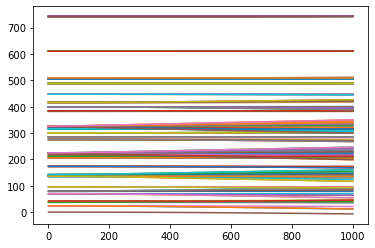

In [34]:
from richmol.convert_units import AUdip_x_Vm_to_invcm, AUpol_x_Vm_to_invcm
import numpy as np
import matplotlib.pyplot as plt


fac1 = AUdip_x_Vm_to_invcm() # conversion factor for dipole[au] * field[V/m] into energy[cm^-1]
fac2 = AUpol_x_Vm_to_invcm() # conversion factor for polarizability[au] * field**2[V**2/m**2] into energy[cm^-1]

energies = []
fz = np.linspace(1, 1000, 10) # max field is MV/cm

for f in fz:

    field = [0, 0, f*1000*100] # X, Y, Z field components in V/m
    enr = []

    for m in dip_m.keys():

        # Hamiltonian
        h = h0_m[m] - dip_m[m] * fac1 * field - 1/2 * pol_m[m] * fac2 * field

        # eigenproblem solution
        e,v = np.linalg.eigh(h.tomat(form='full'))

        enr += [elem for elem in e]

    energies.append(enr)

energies = np.array(energies)

# plot energies vs field
for i in range(energies.shape[1]):
    plt.plot(fz, energies[:,i])